In [1]:
from numpy import*
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
%matplotlib inline

Cilj ovog projekta je provjeriti učinkovitost neuronskih mreža u previđanju dinamike nelinearnih sustava. Konkretno u ovom slučaju promatramo Van der Polov oscilator čija je dinamika dana diferencijalnom jednadžbom:
$$\begin{pmatrix}\dot{x}\\\dot{y}) \end{pmatrix} = \begin{pmatrix}y \\ \mu (1- x^2)y -x \end{pmatrix}$$
Ideja je uzeti neki broj parova $(x,y)$ te izračunati pripadni $(\dot{x},\dot{y})$ i s tim istrenirati neuronsku mrežu da sama za dani $(x,y)$ predviđa $(\dot{x},\dot{y})$.
Pri provjeri kvalitete rezultata često koristim grafove tzv. faznog toka što je u biti vektorsko polje u $x-y$ ravnini gdje je svakoj točki pridružen vektor $(\dot{x},\dot{y})$.

Ovo je egzaktni fazni tok kojeg želimo dobiti neuronskom mrežom.


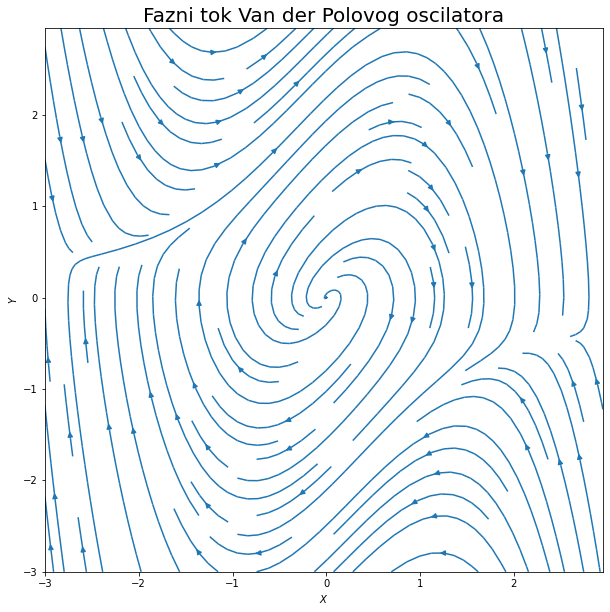

In [2]:
#Korisne funkcije
def van_der_pol(state,t,mu = 1):
    """Generira egzaktnu diferencijalnu jednadžbu sustava"""
    x = state[0]
    dx = state[1]
    d2x = -x  + mu*( 1 - x**2 )*dx
    
    return array([dx,d2x])
dt = 0.01   

def vector_field(x,dx,dt = dt,mu = 1):
    
    ux = dx
    uy = -x + mu*(1 - x**2)*dx
    return ux,uy


x_mesh = arange(-3,3,5e-2)
y_mesh = arange(-3,3,5e-2)
Npts = len(x_mesh)
u = zeros([Npts,Npts])
v = zeros([Npts,Npts])

for i in range(Npts):
    for j in range(Npts):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])

        
X,Y = meshgrid(x_mesh,y_mesh) 
frame,fig =plt.subplots(figsize = (10,10))
fig.streamplot(x_mesh,y_mesh,u,v)
# q = fig.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5],units = "width",color = "blue",label ="fazni tok")
# qk = fig.quiverkey(q, 0.9, 0.9, 2,label = "")
#fig.legend()
fig.set_title("Fazni tok Van der Polovog oscilatora",fontsize = 20)
fig.set_xlabel(r"$X$")
fig.set_ylabel(r"$Y$")
print("Ovo je egzaktni fazni tok kojeg želimo dobiti neuronskom mrežom.")

In [3]:
#Definiranje modela
#Arhitektura 2 x 8 x 8 x 2
model= keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        layers.Dense(2)])


opt =keras.optimizers.Adam(
    learning_rate=0.005)

model.compile(optimizer = opt,
               loss = 'mse')


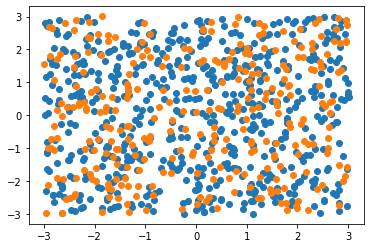

In [4]:
#Generiranje podataka za učenje modela
#Za provjeru i za testiranje modela
eps = 1e-2
Ntrain = 600 #Originalno 600
trainX =  random.uniform(-3,3+eps,(Ntrain,2))
trainY = list()

Ntest = 300
testX =  random.uniform(-3,3+eps,(Ntest,2))
testY = list()

Nvalid = 300
validX =  random.uniform(-3,3+eps,(Nvalid,2))
validY = list()

for i in range(Ntrain):
    trainY.append(vector_field(trainX[i][0],trainX[i][1]))    
for i in range(Ntest):
    testY.append(vector_field(testX[i][0],testX[i][1]))
for i in range(Nvalid):
    validY.append(vector_field(validX[i][0],validX[i][1]))
    
trainY = array(trainY)
testY = array(testY)
validY = array(validY)
plt.scatter(trainX[:,0],trainX[:,1])
plt.scatter(validX[:,0],validX[:,1])

In [5]:
#Treniranje modela
history = model.fit(trainX,trainY,
                   validation_data=(validX,validY),
                    batch_size = 64,
                    epochs = 1000
                   )

Epoch 1/1000
10/10 [==============================] - 1s 33ms/step - loss: 23.4229 - val_loss: 23.1799
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 18.7586 - val_loss: 22.1831
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 17.5488 - val_loss: 21.2134
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: 14.5046 - val_loss: 20.4364
Epoch 5/1000
10/10 [==============================] - 0s 5ms/step - loss: 12.8526 - val_loss: 19.8639
Epoch 6/1000
10/10 [==============================] - 0s 4ms/step - loss: 12.6711 - val_loss: 19.4156
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 11.4320 - val_loss: 19.2206
Epoch 8/1000
10/10 [==============================] - 0s 5ms/step - loss: 10.0877 - val_loss: 19.2945
Epoch 9/1000
10/10 [==============================] - 0s 5ms/step - loss: 8.1060 - val_loss: 19.3767
Epoch 10/1000
10/10 [==============================] - 0s 5ms/step - loss: 5.4817 

Epoch 82/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5508 - val_loss: 0.2980
Epoch 83/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0522 - val_loss: 0.2847
Epoch 84/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3551 - val_loss: 0.2708
Epoch 85/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.7717 - val_loss: 0.2548
Epoch 86/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2539 - val_loss: 0.2467
Epoch 87/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0110 - val_loss: 0.5254
Epoch 88/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0962 - val_loss: 0.1477
Epoch 89/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.7379 - val_loss: 0.1160
Epoch 90/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9463 - val_loss: 0.4821
Epoch 91/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.8952 - val_los

10/10 [==============================] - 0s 4ms/step - loss: 0.8244 - val_loss: 0.1885
Epoch 163/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1490 - val_loss: 0.4743
Epoch 164/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4617 - val_loss: 0.3282
Epoch 165/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2308 - val_loss: 0.2616
Epoch 166/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9245 - val_loss: 0.3140
Epoch 167/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3609 - val_loss: 0.2772
Epoch 168/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0900 - val_loss: 0.1409
Epoch 169/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1014 - val_loss: 0.0649
Epoch 170/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8103 - val_loss: 0.1036
Epoch 171/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0397 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 1.1629 - val_loss: 0.2906
Epoch 243/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4454 - val_loss: 0.1617
Epoch 244/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7547 - val_loss: 0.1104
Epoch 245/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9001 - val_loss: 0.1434
Epoch 246/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0788 - val_loss: 0.2523
Epoch 247/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9056 - val_loss: 0.2936
Epoch 248/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4239 - val_loss: 0.3691
Epoch 249/1000
10/10 [==============================] - 0s 4ms/step - loss: 2.6109 - val_loss: 0.0688
Epoch 250/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1276 - val_loss: 0.2562
Epoch 251/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1884 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.5794 - val_loss: 0.4448
Epoch 323/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9427 - val_loss: 0.4044
Epoch 324/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8948 - val_loss: 0.3068
Epoch 325/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3266 - val_loss: 0.2074
Epoch 326/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7831 - val_loss: 0.1163
Epoch 327/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7396 - val_loss: 0.2578
Epoch 328/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7427 - val_loss: 0.1060
Epoch 329/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.5573 - val_loss: 0.4082
Epoch 330/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0746 - val_loss: 0.0516
Epoch 331/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0583 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.9099 - val_loss: 0.2099
Epoch 403/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.5955 - val_loss: 0.1825
Epoch 404/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9762 - val_loss: 0.1062
Epoch 405/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8090 - val_loss: 0.0613
Epoch 406/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8151 - val_loss: 0.0752
Epoch 407/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3480 - val_loss: 0.0441
Epoch 408/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8089 - val_loss: 0.0485
Epoch 409/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1324 - val_loss: 0.1069
Epoch 410/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.5300 - val_loss: 0.0859
Epoch 411/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8534 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.1000
Epoch 483/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8685 - val_loss: 0.3144
Epoch 484/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.6721 - val_loss: 0.1137
Epoch 485/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.6760 - val_loss: 0.1477
Epoch 486/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0096 - val_loss: 0.2985
Epoch 487/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3466 - val_loss: 0.1582
Epoch 488/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.5855 - val_loss: 0.2810
Epoch 489/1000
10/10 [==============================] - 0s 10ms/step - loss: 1.1499 - val_loss: 0.0666
Epoch 490/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.5852 - val_loss: 0.1459
Epoch 491/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.7245 - val_loss: 0

10/10 [==============================] - 0s 5ms/step - loss: 1.2861 - val_loss: 0.0854
Epoch 563/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.1324 - val_loss: 0.0867
Epoch 564/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.7247 - val_loss: 0.1489
Epoch 565/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.4090 - val_loss: 0.3102
Epoch 566/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3767 - val_loss: 0.1721
Epoch 567/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9091 - val_loss: 0.2908
Epoch 568/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9115 - val_loss: 0.4734
Epoch 569/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8999 - val_loss: 0.2914
Epoch 570/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1271 - val_loss: 0.1013
Epoch 571/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0293 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 1.0046 - val_loss: 0.3780
Epoch 643/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.9504 - val_loss: 0.2249
Epoch 644/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.2156 - val_loss: 0.0329
Epoch 645/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.6733 - val_loss: 0.3251
Epoch 646/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.9977 - val_loss: 0.1498
Epoch 647/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.6077 - val_loss: 0.1858
Epoch 648/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.8131 - val_loss: 0.1183
Epoch 649/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.2580 - val_loss: 0.1579
Epoch 650/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.9167 - val_loss: 0.0753
Epoch 651/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.3216 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 2.0992 - val_loss: 0.3703
Epoch 723/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0404 - val_loss: 0.2957
Epoch 724/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1284 - val_loss: 0.2837
Epoch 725/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8377 - val_loss: 0.2698
Epoch 726/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3341 - val_loss: 0.2288
Epoch 727/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7418 - val_loss: 0.0844
Epoch 728/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8890 - val_loss: 0.1343
Epoch 729/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8670 - val_loss: 0.1032
Epoch 730/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0368 - val_loss: 0.1160
Epoch 731/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7466 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 1.3592 - val_loss: 0.1892
Epoch 803/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4338 - val_loss: 0.2758
Epoch 804/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1481 - val_loss: 0.5137
Epoch 805/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1905 - val_loss: 0.3404
Epoch 806/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.8861 - val_loss: 0.2525
Epoch 807/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.8774 - val_loss: 0.2051
Epoch 808/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3113 - val_loss: 0.0846
Epoch 809/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.6895 - val_loss: 0.2152
Epoch 810/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.9440 - val_loss: 0.2159
Epoch 811/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.7357 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 1.3374 - val_loss: 0.2270
Epoch 883/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.4669 - val_loss: 0.5627
Epoch 884/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9254 - val_loss: 0.1679
Epoch 885/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8673 - val_loss: 0.3795
Epoch 886/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.7616 - val_loss: 0.1316
Epoch 887/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9514 - val_loss: 0.0840
Epoch 888/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.9807 - val_loss: 0.0346
Epoch 889/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1285 - val_loss: 0.1085
Epoch 890/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8627 - val_loss: 0.2358
Epoch 891/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5794 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.8530 - val_loss: 0.0726
Epoch 963/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.0850 - val_loss: 0.1300
Epoch 964/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.7829 - val_loss: 0.2109
Epoch 965/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0881 - val_loss: 0.1023
Epoch 966/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.5104 - val_loss: 0.0884
Epoch 967/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.8437 - val_loss: 0.1184
Epoch 968/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0483 - val_loss: 0.1703
Epoch 969/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.4343 - val_loss: 0.2173
Epoch 970/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1996 - val_loss: 0.5074
Epoch 971/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5760 - val_loss: 0.

10/10 [==============================] - 0s 637us/step - loss: 0.0612


0.061228178441524506

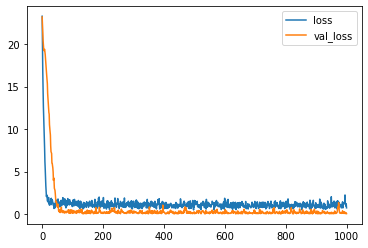

In [6]:
#Točnost modela
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
model.evaluate(testX,testY)

Prvi istrenirani model učio je na skupu uniformno distribuirani tokčaka u $x-y$ ravnini te se čini da poprilično dobro predviđa ponašanje sustava (vidi preklopljenu sliku - ćelija niže). Problem s ovim pristupom jest da u stvarnosti ne znamo kako se sustav ponaša u velikom broju početnih točaka, ono što u praksi imamo najčešće je nekolicina trajektorija po kojima je evolvirao sustav. 

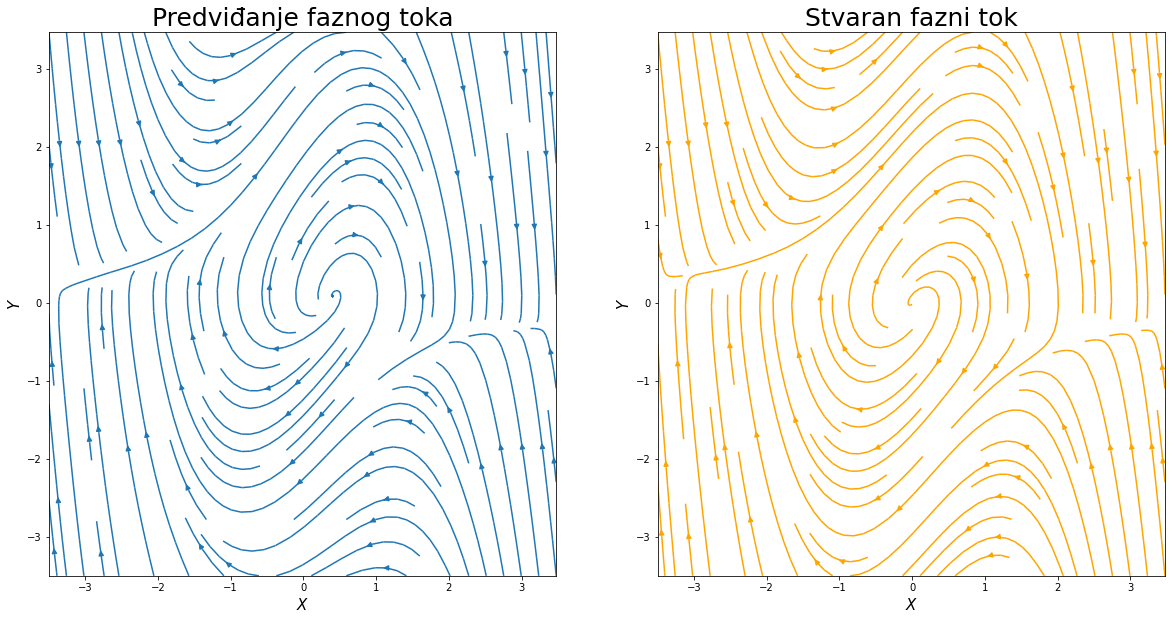

In [7]:
#Provjera kako model radi na nasumično odabranim točkama
#Cilj mu je pogoditi fazni tok u točku odnosno diferencijanu jednadžbu
x_mesh = arange(-3.5,3.5,7/300)
y_mesh = arange(-3.5,3.5,7/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
frame.savefig("Usporedba")


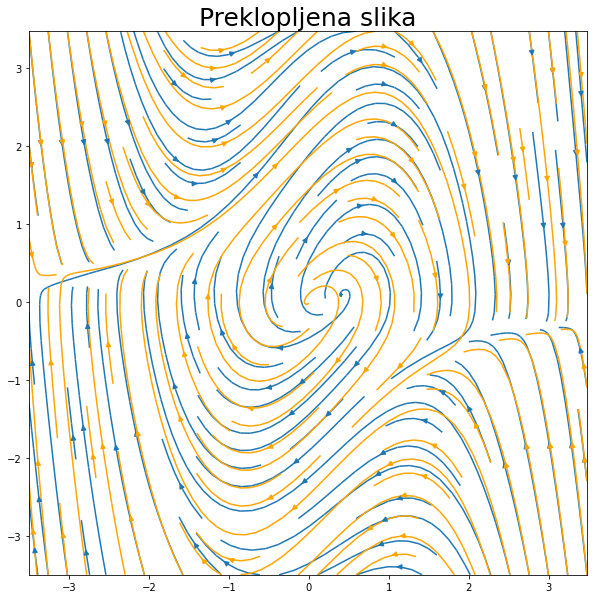

In [8]:
frame,fig = plt.subplots(figsize = (10,10))
dns = 1
fig.streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = dns)
fig.streamplot(x_mesh,y_mesh,u,v,density = dns,color ="orange")

fig.set_title("Preklopljena slika",fontsize = 25)
frame.savefig("Preklop")


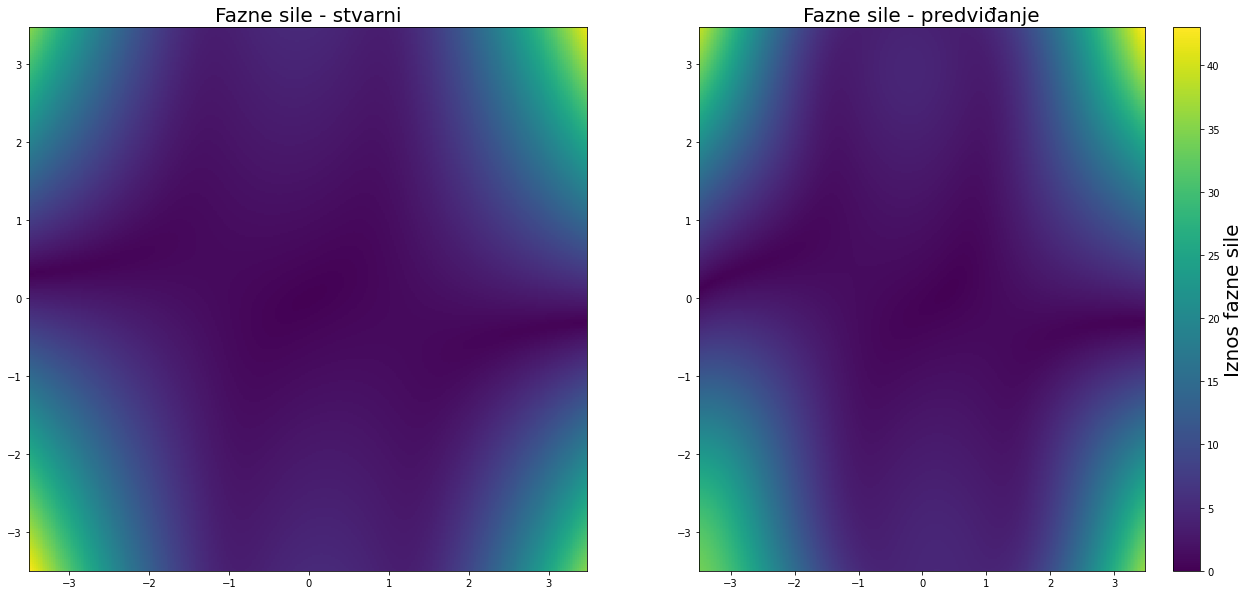

In [9]:
size_real = zeros((300,300))
size_neural = zeros((300,300))

for i in range(300):
    for j in range(300):
        size_real[j,i] = sqrt(u[j,i]**2 + v[j,i]**2)
        size_neural[j,i] = sqrt(pred[j,i,0]**2 + pred[j,i,1]**2)
        
X,Y = meshgrid(x_mesh,y_mesh)
frame,fig =plt.subplots(1,2,figsize =(22,10))
mp = fig[0].pcolor(X,Y,size_real)
fig[1].pcolor(X,Y,size_neural)
cs = frame.colorbar(mp,cmap='jet')
cs.set_label('Iznos fazne sile',size=20)
fig[0].set_title("Fazne sile - stvarni",fontsize =20)
fig[1].set_title("Fazne sile - predviđanje",fontsize =20)
frame.savefig("Iznos_faznih sila")

In [10]:
#Učenje kontinuacije dinamike
# #Podatke uzima s jedne krivulje
t = arange(0,15,1e-2)
L = len(t)
Npts = 500
initial_train =[0.1,0.1]
train_traj = odeint(van_der_pol,initial_train,t)
X_train = train_traj[::2,:]
#Y_train = zeros((Npts,2))
# initial_train = [3,-3]
# train_traj = odeint(van_der_pol,initial_train,t)
# X_train = concatenate((X_train,train_traj[::2,:]))

initial_val = [0.3,0.4]
val_traj = odeint(van_der_pol,initial_val,t)
X_val = val_traj[::2,:]
#Y_val = zeros((Npts,2))



initial_test = [-0.21,0.15]
test_traj = odeint(van_der_pol,initial_test,t)
X_test = test_traj[::2,:]
#Y_test = zeros((Npts,2))

Y_train,Y_test,Y_val = [],[],[]

for i in range(len(X_train)):
#     Y_train[i,:] += vector_field(X_train[i,0],X_train[i,1])
#     Y_val[i,:] += vector_field(X_val[i,0],X_val[i,1])
#     Y_test[i,:] += vector_field(X_test[i,0],X_test[i,1])
    Y_train.append(vector_field(X_train[i,0],X_train[i,1]))

for i in range(len(X_val)):
    Y_test.append(vector_field(X_test[i,0],X_test[i,1]))
    Y_val.append(vector_field(X_val[i,0],X_val[i,1]))
    
Y_train = array(Y_train)
Y_test = array(Y_test)
Y_val = array(Y_val)


In [11]:
X_train[0]
    

array([0.1, 0.1])

U slijedećem pokušaju model je zapravo isti, razlika jest u skupu podataka na kojima uči. U ćeliji iznad pripremljeni su skupovi za trening i za provjeru modela, osnovni je cilj vidjeti kako neuronska mreža uči sa zadanog skupa te, još bitnije, kako ekstrapolira svoja predviđanja u područja koja nikad nije vidjela.
Rezultati su znatno manje impresivni nego u slučaju s uniformno distribuiranim točkama, tim više zbog pseudoslučajne prirode procesa treniranja neuronske mreže različite iteracije daju različita predviđanja. Dakako model bi se mogao poboljšati pametnijom obradom podataka, jedan mogući prijedlog bi bio dodati nelinearne kombinacje tipe $x^2,y^2,xy...$ kao ulazne parametre, no to nije bilo potrebno jer već znamo kakva je prava dinamika sustava. Ono što se nadam da sam uspio pokazati jest da usprkost velikoj prediktivnoj moći neuronskih mreža, kada ih se prepusti samim sebi, bez ljudskog nadzora treba njihova predviđanja uzimati sa zrnom skepse.


In [12]:
# #Definiranje modela2 koji predviđa trajektoriju u naprijed
act = "sigmoid"

# model2= keras.Sequential([layers.BatchNormalization(input_shape = [2]),
#                           layers.Dense(8,activation = act),
#                         layers.BatchNormalization(),
#                         layers.Dense(8,activation = "softmax"),
#                           layers.BatchNormalization(),
                          
                          
#                         layers.Dense(8,activation = act),
#                         layers.BatchNormalization(),
                         
                          
                          
#                         layers.Dense(2)])

model2 = keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                           layers.Dense(8,activation = "swish"),
                           layers.BatchNormalization(),
                           layers.Dense(8,activation  ="swish"),
                           layers.BatchNormalization(),
                           layers.Dense(2)
])

#Optimizaciski algoritam
opt =keras.optimizers.Adam(
    learning_rate=0.002)
#mse - Mean square error - to želiš minimizirati
model2.compile(optimizer = opt,
               loss = 'mse')


early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.1, # minimium amount of change to count as an improvement
    patience=300, # how many epochs to wait before stopping
    restore_best_weights=True,
)




In [13]:
history2 = model2.fit(X_train,Y_train,
                      validation_data = (X_val,Y_val),
                      batch_size = 64,
                      epochs = 1000,
                   callbacks =[early_stopping]
)




Epoch 1/1000
12/12 [==============================] - 1s 12ms/step - loss: 5.3748 - val_loss: 2.4094
Epoch 2/1000
12/12 [==============================] - 0s 3ms/step - loss: 3.1063 - val_loss: 2.2138
Epoch 3/1000
12/12 [==============================] - 0s 3ms/step - loss: 1.9589 - val_loss: 2.0569
Epoch 4/1000
12/12 [==============================] - 0s 3ms/step - loss: 1.2990 - val_loss: 1.9403
Epoch 5/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.9252 - val_loss: 1.8499
Epoch 6/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.6720 - val_loss: 1.7797
Epoch 7/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.6021 - val_loss: 1.7054
Epoch 8/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.5440 - val_loss: 1.6443
Epoch 9/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.6144 - val_loss: 1.5905
Epoch 10/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.5503 - val_loss: 1.545

Epoch 82/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0651 - val_loss: 0.0240
Epoch 83/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0850 - val_loss: 0.0274
Epoch 84/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.1544 - val_loss: 0.0279
Epoch 85/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0864 - val_loss: 0.0245
Epoch 86/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0767 - val_loss: 0.0310
Epoch 87/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0911 - val_loss: 0.0227
Epoch 88/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0791 - val_loss: 0.0200
Epoch 89/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.1054 - val_loss: 0.0220
Epoch 90/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0793 - val_loss: 0.0209
Epoch 91/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0676 - val_los

12/12 [==============================] - 0s 8ms/step - loss: 0.0564 - val_loss: 0.0145
Epoch 163/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0693 - val_loss: 0.0148
Epoch 164/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0983 - val_loss: 0.0152
Epoch 165/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.0161
Epoch 166/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0807 - val_loss: 0.0160
Epoch 167/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0879 - val_loss: 0.0208
Epoch 168/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0625 - val_loss: 0.0249
Epoch 169/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.1075 - val_loss: 0.0242
Epoch 170/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0571 - val_loss: 0.0199
Epoch 171/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.1298 - val_loss: 0.

12/12 [==============================] - 0s 5ms/step - loss: 0.0495 - val_loss: 0.0139
Epoch 243/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0914 - val_loss: 0.0233
Epoch 244/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0664 - val_loss: 0.0155
Epoch 245/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0595 - val_loss: 0.0097
Epoch 246/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0660 - val_loss: 0.0103
Epoch 247/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0142
Epoch 248/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0460 - val_loss: 0.0185
Epoch 249/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.0109
Epoch 250/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0771 - val_loss: 0.0177
Epoch 251/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0599 - val_loss: 0.

12/12 [==============================] - 0s 6ms/step - loss: 0.0549 - val_loss: 0.0075
Epoch 323/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0378 - val_loss: 0.0080
Epoch 324/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0569 - val_loss: 0.0102
Epoch 325/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0634 - val_loss: 0.0103
Epoch 326/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0825 - val_loss: 0.0142
Epoch 327/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0675 - val_loss: 0.0111
Epoch 328/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0630 - val_loss: 0.0122
Epoch 329/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0715 - val_loss: 0.0085
Epoch 330/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0562 - val_loss: 0.0110
Epoch 331/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0515 - val_loss: 0.

12/12 [==============================] - 0s 4ms/step - loss: 0.0593 - val_loss: 0.0072
Epoch 403/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0080
Epoch 404/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0734 - val_loss: 0.0071
Epoch 405/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0077
Epoch 406/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0073
Epoch 407/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0085
Epoch 408/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.1303 - val_loss: 0.0068
Epoch 409/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0084
Epoch 410/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0097
Epoch 411/1000
12/12 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.

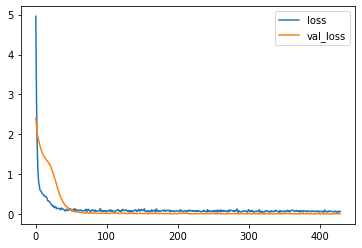

In [14]:
history_df2 = pd.DataFrame(history2.history
                        )
history_df2.loc[:,['loss','val_loss']].plot()

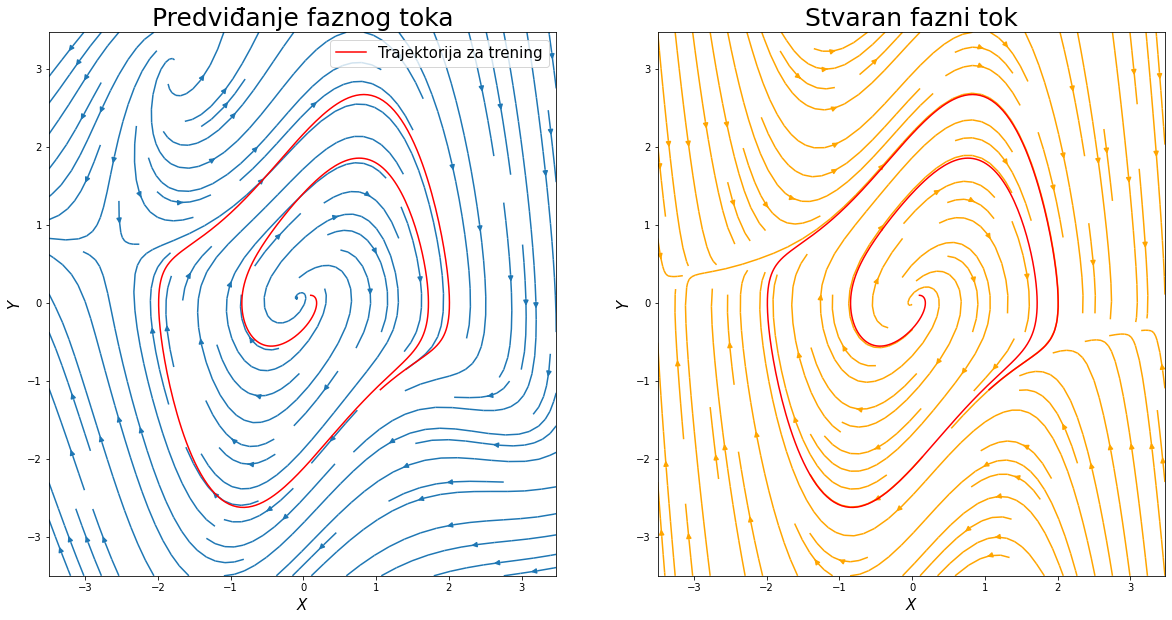

In [15]:
span = 3.5

x_mesh = arange(-span,span,2*span/300)
y_mesh = arange(-span,span,2*span/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model2.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
#fig[0].plot(X,Y)
fig[0].plot(X_train[:,0],X_train[:,1],color ="red",label ="Trajektorija za trening")

fig[1].plot(X_train[:,0],X_train[:,1],color = "red")
fig[0].legend(fontsize = 15)
frame.savefig("Krivulje_usporedba")